In [436]:
from sklearn.svm import SVC
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from math import exp

# SVM example

In [23]:
data = pd.read_csv("C:/Users/U_M0SLV/Downloads/svm-data.csv", header = None)
X=data[[1,2]]
Y=data[0]

In [15]:
svc1 = SVC(C=100000, random_state=241)
svc1 = svc1.fit(X, Y)

In [21]:
print "Supporting vectors: "
svc1.support_

Supporting vectors: 


array([3, 4, 9])

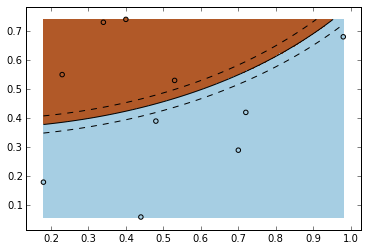

In [50]:
plt.figure(1)
plt.scatter(X[1], X[2], c=Y, zorder=10, cmap=plt.cm.Paired)

plt.axis('tight')
x_min = X[[1]].min()[1]
x_max = X[[1]].max()[1]
y_min = X[[2]].min()[2]
y_max = X[[2]].max()[2]

XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
Z = svc1.decision_function(np.c_[XX.ravel(), YY.ravel()])
# Put the result into a color plot
Z = Z.reshape(XX.shape)
plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])
plt.show()

# SVM example with TF-IDF

In [60]:
newsgroups = datasets.fetch_20newsgroups(
                    subset='all', 
                    categories=['alt.atheism', 'sci.space']
             )

In [62]:
Y=newsgroups.target
X=newsgroups.data

In [73]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(X)

In [81]:
grid = {'C': np.power(10.0, np.arange(-5, 6))}
cv = KFold(Y.size, n_folds=5, shuffle=True, random_state=241)
clf = SVC(kernel='linear', random_state=241)
gs = GridSearchCV(clf, grid, scoring='accuracy', cv=cv)
gs.fit(tfidf, Y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=1786, n_folds=5, shuffle=True, random_state=241),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=241,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='accuracy', verbose=0)

In [114]:
best_score=max([a.mean_validation_score for a in gs.grid_scores_])
print [a.parameters for a in gs.grid_scores_ if a.mean_validation_score == best_score]
print gs.best_params_

[{'C': 1.0}, {'C': 10.0}, {'C': 100.0}, {'C': 1000.0}, {'C': 10000.0}, {'C': 100000.0}]
{'C': 1.0}


In [113]:
clf = SVC(kernel='linear', random_state=241, C = 1.0)
model = clf.fit(tfidf,Y)

In [103]:
coeff = model.coef_
coeff = np.sort(abs(coeff))

In [167]:
#top 10 words
res=[tfidf_vectorizer.get_feature_names()[i] 
       for i in np.argsort(abs(np.asarray(gs.best_estimator_.coef_.todense()).reshape(-1)))[-10:]]
print sorted(res)

# Gradient descent for logistic regression

In [278]:
data = pd.read_csv("C:/Users/U_M0SLV/Downloads/data-logistic.csv", header = None)
X=data[[1,2]]
Y=data[0]

In [383]:
def grad_dsc_step(w, y, x, learningRate, **kwargs):
    N = len(y)
    w_gradient = np.zeros(x.shape[1])
    for i in range(0, N):
        y_i = y[i]
        w_gradient += y_i*x.loc[i]*(1.0-1.0/(1+exp(-y_i*sum(x.loc[i]*w))))
    if 'regularization' in kwargs and kwargs['regularization'] == 'L2':
        return w + 1.0 * learningRate / N * w_gradient - learningRate*kwargs['C']*w
    else:
        return w + 1.0 * learningRate / N * w_gradient

In [397]:
def grad_dsc(y, x, learningRate, conv, **kwargs):
    d = 1
    i = 0
    weights = np.zeros(x.shape[1])
    if 'regularization' in kwargs and 'C' not in kwargs:
        print 'Parameter C is required in case of regularization'
        return None, None
    while d > conv and i < kwargs['n_max']:
        weights_new = grad_dsc_step(weights, y, x, k, **kwargs)
        d = np.linalg.norm(weights_new-weights)
        weights = weights_new
        i += 1
    return weights, i

In [398]:
w, it = grad_dsc(Y, X, 0.1, 10**-5, n_max = 10**3)
predictions = (w*X).sum(axis=1).apply(lambda x: 1.0/(1.0+exp(-x)))
w_r, it_r = grad_dsc(Y, X, 0.1, 10**-5, n_max = 10**3, regularization = "L2", C = 10.0)
predictions_r = (w_r*X).sum(axis=1).apply(lambda x: 1.0/(1.0+exp(-x)))

In [399]:
print "ROC-AUC without regularization is {0:.3f} and with L2-regularization it's {1:.3f}".format(
    roc_auc_score(Y, predictions), roc_auc_score(Y, predictions_r))

ROC-AUC without regularization is 0.927 and with L2-regularization it's 0.936


# Classification metrics

In [457]:
data = pd.read_csv("C:/Users/U_M0SLV/Downloads/classification.csv")

In [431]:
print "TP: {0:.0f}, TN: {1:.0f}, FP: {2:.0f}, FN: {3:.0f}".format(
    data[(data['true']==1) & (data['pred'] == 1)]['true'].count(),
    data[(data['true']==0) & (data['pred'] == 0)]['true'].count(),
    data[(data['true']==0) & (data['pred'] == 1)]['true'].count(),
    data[(data['true']==1) & (data['pred'] == 0)]['true'].count())

TP: 43, TN: 64, FP: 34, FN: 59


In [458]:
print "Accuracy: {0:.2f}, precision: {1:.2f}, recall: {2:.2f}, f1: {3:.2f}".format(accuracy_score(data['true'], data['pred']),
                                                                      precision_score(data['true'], data['pred']),
                                                                      recall_score(data['true'], data['pred']),
                                                                      f1_score(data['true'], data['pred']))

Accuracy: 0.54, precision: 0.56, recall: 0.42, f1: 0.48


In [432]:
data = pd.read_csv("C:/Users/U_M0SLV/Downloads/scores.csv")

In [435]:
print "ROA-AUC for logreg: {0:.3f}, svm: {1:.3f}, knn: {2:.3f}, tree: {3:.3f}".format(roc_auc_score(data['true'], data['score_logreg']),
                                                                                      roc_auc_score(data['true'], data['score_svm']),
                                                                                      roc_auc_score(data['true'], data['score_knn']),
                                                                                      roc_auc_score(data['true'], data['score_tree']))

ROA-AUC for logreg: 0.719, svm: 0.709, knn: 0.635, tree: 0.692


In [456]:
for c in ('score_logreg', 'score_svm', 'score_knn', 'score_tree'):
    pr, rc, th = precision_recall_curve(data['true'], data[c])
    print "Accuracy under recall > 0.7 for {0} is {1:.3f}".format(c, pr[np.where(rc > 0.7)].max())

Accuracy under recall > 0.7 for score_logreg is 0.630
Accuracy under recall > 0.7 for score_svm is 0.623
Accuracy under recall > 0.7 for score_knn is 0.607
Accuracy under recall > 0.7 for score_tree is 0.652
